## Assigning values for wildfire hazard potential to school districts

This notebook will explain the process for changing the unit of analysis of wildfire hazard potential to school districts.

In [1]:
# load packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.express as px # for mapping
import numpy as np
import rioxarray as rioxr
import xarray as xr
from rasterio.features import rasterize # for rasterizing polygons

In [2]:
## read in data
# wildfire hazard potential for the continental US
whp_fp = os.path.join(os.getcwd(), 'data', 'wildfire_hazard_potential', 'whp2023_cls_conus.tif')
whp = rioxr.open_rasterio(whp_fp)

In [ ]:
# exploration
#type(whp)

# print shape and data type
print('shape:', whp.shape)
print('data type:', whp.dtype)

In [ ]:
np.unique(whp)

## Viewing the data

We notice that we have values 1-7, and 255 in our raster. According to the metadata, values 1-5 correspond, in ascending order, to very low, low, moderate, high, and very high wildfire hazard potential. 6 refers to non-burnable land and 7 to water. 255 refers to the no data value.

In [4]:
# drop the extra band and dimensions
whp = whp.squeeze().drop('band')

In [ ]:
# plot the data
#whp.plot()

In [ ]:
# plot the raster values in the data
fig, ax = plt.subplots()
whp.plot.hist(color = "purple")
ax.set(title = "Distribution of cell values",
      xlabel = "",
      ylabel = "number of pixels")
plt.show()

### clipping to California state boundary

Since our data is at the level of the entire US, we want to crop just to the state of California

In [6]:
# read in US states
states_fp = os.path.join(os.getcwd(), 'data', 'states', 'tl_2023_us_state.shp')
states = gpd.read_file(states_fp)

# filter to California
ca = states[states['NAME'] == "California"]

<AxesSubplot:>

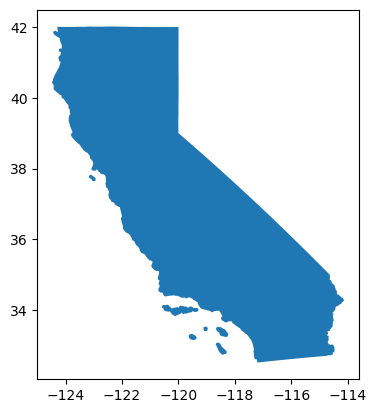

In [7]:
ca.plot()

In [ ]:
# check that the CRS match
print(whp.rio.crs)
print(ca.crs)

In [8]:
# reproject California crs to match the whp layer
ca = ca.to_crs(whp.rio.crs)

In [10]:
# clip raster to the CA polygon
whp_ca = whp.rio.clip(ca.geometry.values)

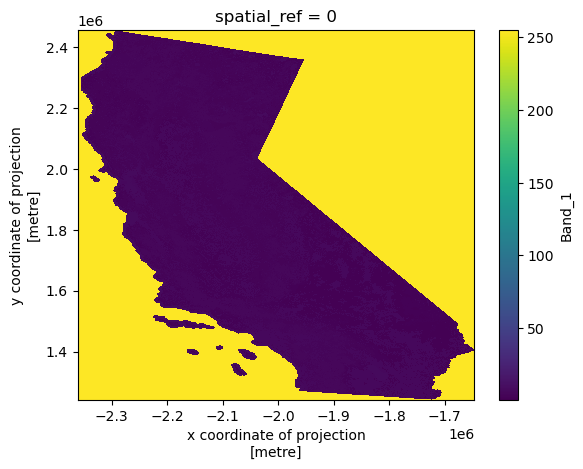

In [11]:
# plot to check that it worked
whp_ca.plot(robust = True)

### modifying the no data value

In [ ]:
# figure out what our nodata value is 
whp_ca.rio.nodata

In [32]:
# turn no data values into nan using where()
# convert values 6 and 7 into NaN also
# where() selects pixels that meet the condition
whp_ca = whp_ca.where((whp_ca != 255) & (whp_ca != 6) & (whp_ca != 7))

In [ ]:
# check to see what the values are now
np.unique(whp_ca)

In [ ]:
# check the update
whp_ca.plot()

### reclassifying the raster- WORK IN PROGRESS

From the metadata: https://www.fs.usda.gov/rds/archive/products/RDS-2015-0047-4/_metadata_RDS-2015-0047-4.html

Values:
1- very low
2- low
3- moderate
4- high
5- very high
6- non-burnable
7- water

In [ ]:
# viewing the distribution of pixel values
fig, ax = plt.subplots()
whp_ca.plot.hist(color = "purple")
ax.set(title = "Distribution of cell values",
      xlabel = "",
      ylabel = "number of pixels")
plt.show()

In [ ]:
# create a dataframe with the class names
class_names = pd.DataFrame({
    'names': ['very low', 'low', 'moderate', 'high', 'very high', 'non-burnable', 'water'],
    'value': [1, 2, 3, 4, 5, 6, 7]
})

In [ ]:
## mapping from integer to character strings

# define class mapping as a list
# leave the first one blank because our values start at 1 but we don't want to confuse with the 0 index
class_mapping = ['very low', 'low', 'moderate', 'high', 'very high', 'non-burnable', 'water']


### assigning raster values to polygons

-read in schools data
-create raster mask from our school district polygons

In [33]:
# read in CA school districts data
ca_schools_fp = os.path.join(os.getcwd(), 'data', 'schools', 'California_School_District_Areas_2022-23.shp')
ca_schools = gpd.read_file(ca_schools_fp)

In [34]:
# match the crs of schools districts to our whp raster
ca_schools = ca_schools.to_crs(whp_ca.rio.crs)

In [ ]:
# filter a subset for testing with zonal statistics
schools_sub = ca_schools[ca_schools.CountyName == 'Alameda']

schools_sub.head()

In [ ]:
## create a raster mask based on our school district polygons
schools_mask = rasterize(shapes = ca_schools.geometry, # geometries to rasterize
                        out_shape = whp_ca.shape, # shape of output raster
                        transform = whp_ca.rio.transform(), # transformation of raster
                        all_touched = True) # all pixels touched by geometries will be burned in

In [ ]:
# plot the mask
plt.imshow(schools_mask)

In [ ]:
# what's contained in the raster mask?
np.unique(schools_mask)

In [ ]:
# apply mask to whp_ca raster
# what this does is multiply 
whp_schools = whp_ca * schools_mask

whp_schools.plot(robust = True)

In [ ]:
# convert 0s to nan value so those pixels don't factor into the mean calculation
whp_schools = whp_schools.where(whp_schools !=0, other = np.nan)

In [ ]:
np.unique(whp_schools)

### using a for loop with zonal statistics
- need to somehow average all of the values in each raster
- right now we have 0-7, so we need to convert 0, 6,7 to 0?
    - justification- since we're averaging, those ones won't play into the average at all
- not sure how it's treating NaN values, so we might have to use nanmean to calculate
    

In [ ]:
# using a for loop to assign values to each schools district
# rasterize each individual district, then 
# testing with a subset of california schools
whp = []

for i in schools_sub.index:
    mask = rasterize([schools_sub.loc[i, 'geometry']],
                    out_shape = whp_ca.shape, # shape of output raster
                    transform = whp_ca.rio.transform(), # transformation of raster
                    all_touched = True)
    whp_val = np.round((whp_ca * mask).mean(skipna = True).item(), decimals = 0)
    whp.append(whp_val)

In [35]:
## different test of for loop
whp = []

for i, row in ca_schools.iterrows():
    # rasterize the schools and create a mask
    mask = rasterize([row['geometry']],
                     out_shape = whp_ca.shape,
                     transform = whp_ca.rio.transform(),
                     all_touched = True)

    # apply the mask to raster and calculate the mean
    # adding the where statement only selects data points that fall within the school district polygon the for loop is on
    whp_val = np.round((whp_ca.where(mask == 1)).mean(skipna = True).item(), decimals = 0)
    whp.append(whp_val)

In [36]:
ca_schools['whp'] = whp

ca_schools.head()

ca_schools.whp.min()

1.0

In [37]:
# turning the whp numeric values into their corresponding categories
whp_cat = {1: "very low", 2: "low", 3: "moderate", 4: "high", 5: "very high"}

# Use the map function to apply the mapping to the 'whp' column
ca_schools['whp_cat'] = ca_schools['whp'].map(whp_cat)

In [18]:
ca_schools.head()

,OBJECTID,Year,FedID,CDCode,CDSCode,CountyName,DistrictNa,DistrictTy,GradeLow,GradeHigh,...,SWDcount,SWDpct,SEDcount,SEDpct,DistrctAre,Shape__Are,Shape__Len,geometry,whp,whp_cat
0,1,2022-23,0601770,0161119,01611190000000,Alameda,Alameda Unified,Unified,KG,12,...,1277.0,12.3,3765.0,36.3,11.455570,4.755489e+07,56522.982683,"MULTIPOLYGON (((-2260744.713 1946121.674, -226...",3.0,moderate
1,2,2022-23,0601860,0161127,01611270000000,Alameda,Albany City Unified,Unified,KG,12,...,307.0,8.7,1009.0,28.6,1.703654,7.096327e+06,12696.382797,"POLYGON ((-2260513.394 1966094.400, -2260523.6...",3.0,moderate
2,3,2022-23,0604740,0161143,01611430000000,Alameda,Berkeley Unified,Unified,KG,12,...,1076.0,11.9,2390.0,26.3,10.483362,4.364648e+07,43695.341538,"POLYGON ((-2257950.970 1965346.681, -2257953.3...",4.0,high
3,4,2022-23,0607800,0161150,01611500000000,Alameda,Castro Valley Unified,Unified,KG,12,...,931.0,10.1,3270.0,35.5,68.442604,2.838285e+08,142492.767565,"MULTIPOLYGON (((-2245385.176 1932025.578, -224...",3.0,moderate
4,5,2022-23,0612630,0161168,01611680000000,Alameda,Emery Unified,Unified,KG,12,...,79.0,12.6,395.0,63.0,1.289416,5.363392e+06,13741.272894,"POLYGON ((-2263409.658 1959061.418, -2263459.1...",3.0,moderate


## Plotting


In [ ]:
# set up figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# 
ca_schools.plot(column='whp_cat', ax=ax, legend=True)

# remove x and y axis
ax.set_axis_off()

plt.show()

## interactive map

In [49]:
# subset to Ventura County
vt_schools = ca_schools[ca_schools['CountyName'] == 'Ventura']

### prep for plotting

In [54]:
## preparation for plotting
# for plotting with ploly, make sure that the layer is in EPSG 4326
vt_schools = vt_schools.to_crs(4326)

# also have to set the index as the feature we're plotting. Here, it's district, so we do it by district name
vt_schools = vt_schools.set_index('DistrictNa')

In [21]:
# define color mapping for plotting
whp_map = {
    'very low':'#ffffb2',
    'low':'#fecc5c',
    'moderate':'#fd8d3c',
    'high':'#f03b20',
    'very high':'#bd0026'
}

In [50]:
# reorder categories in our data
# set the order
order = ['very low', 'low', 'moderate', 'high']

# reorder categories
vt_schools['whp_cat'] = pd.Categorical(vt_schools['whp_cat'], categories = order, ordered = True)

### plotting an interactive map

In [1]:

# 'locations' corresponds to the index of your GeoDataFrame, so make sure it's meaningful or set it as needed
# 'color' is the column you want to use to differentiate the areas (similar to 'column' in geopandas.plot())
fig = px.choropleth(vt_schools, 
                    geojson = vt_schools.geometry, 
                    locations = vt_schools.index, 
                    color = 'whp_cat',
                    color_discrete_map = whp_map,
                    category_orders = {'whp_cat': order}
                    )

fig.update_geos(fitbounds="locations", visible=False)

fig.update_layout(width=600, height=600)

# Show the interactive plot
fig.show()

NameError: name 'px' is not defined

### Faking sea level rise

In [51]:
vt_schools['slr'] = 0

In [52]:
vt_schools.loc[vt_schools['DistrictNa'] == 'Oak Park Unified', 'slr'] = 100

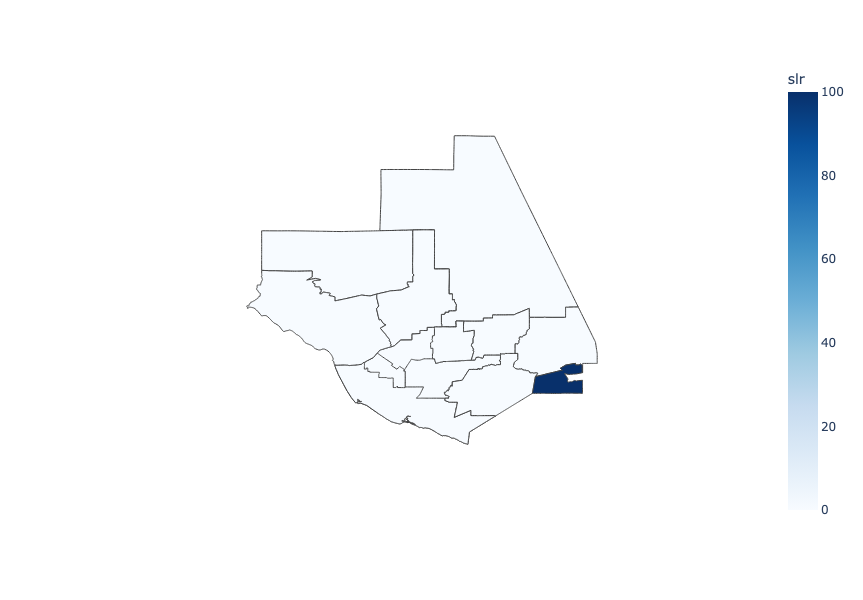

In [56]:

# 'locations' corresponds to the index of your GeoDataFrame, so make sure it's meaningful or set it as needed
# 'color' is the column you want to use to differentiate the areas (similar to 'column' in geopandas.plot())
fig = px.choropleth(vt_schools, 
                    geojson = vt_schools.geometry, 
                    locations = vt_schools.index, 
                    color = 'slr',
                    color_continuous_scale = 'Blues')

fig.update_geos(fitbounds="locations", visible=False)

fig.update_layout(width=600, height=600)

# Show the interactive plot
fig.show()